In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Richardson-Lucy Deconvolution Benchmark Setup
"""
This canvas sets up the environment to benchmark Richardson-Lucy deconvolution
on the MRI test dataset. It includes all necessary imports, dataset loader,
PSF/kernel definition, and placeholders for running the RL algorithm.
"""
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import zipfile, io
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration
from tqdm import tqdm
import math

In [5]:
# ---------------------------------------------
# 1. Transforms & Dataset Loader
# ---------------------------------------------
mean, std = [0.1781], [0.1976]
target_size = (256, 256)
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

class PairedZipDataset(torch.utils.data.Dataset):
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip, self.noisy_zip = clean_zip, noisy_zip
        with zipfile.ZipFile(clean_zip, 'r') as zf:
            self.files = [Path(f).name for f in zf.namelist()
                          if f.startswith('clean/') and not f.endswith('/')]
        self.transform = transform or (lambda x: x)
        self.zc = None; self.zn = None
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        if self.zc is None: self.zc = zipfile.ZipFile(self.clean_zip)
        if self.zn is None: self.zn = zipfile.ZipFile(self.noisy_zip)
        fn = self.files[idx]
        clean = Image.open(io.BytesIO(self.zc.read(f'clean/{fn}'))).convert('L')
        noisy = Image.open(io.BytesIO(self.zn.read(f'noisy/{fn}'))).convert('L')
        return self.transform(noisy), self.transform(clean)

In [6]:
# ---------------------------------------------
# 2. Prepare Test DataLoader
# ---------------------------------------------
batch_size = 8  # adjust as needed

test_ds = PairedZipDataset(
    '/content/drive/MyDrive/IA2/dataset/test_clean.zip',
    '/content/drive/MyDrive/IA2/dataset/test_noisy.zip',
    val_tf
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)


In [7]:
# ---------------------------------------------
# 3. PSF / Kernel Definition
# ---------------------------------------------
psf_size = 5
sigma = 1.0
x = np.arange(psf_size) - (psf_size // 2)
y = x[:, None]
psf = np.exp(-(x**2 + y**2) / (2 * sigma**2))
psf /= psf.sum()

In [8]:
!pip install pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

RL Benchmark: 100%|██████████| 250/250 [04:46<00:00,  1.15s/it]


RL Benchmark - MSE: 0.0061, SSIM: 0.4946, PSNR: 23.98dB


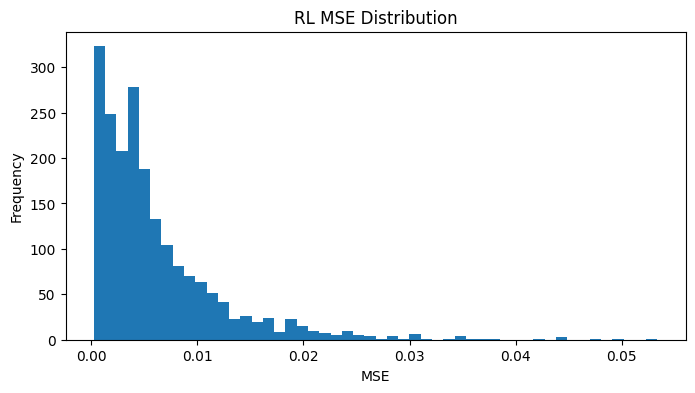

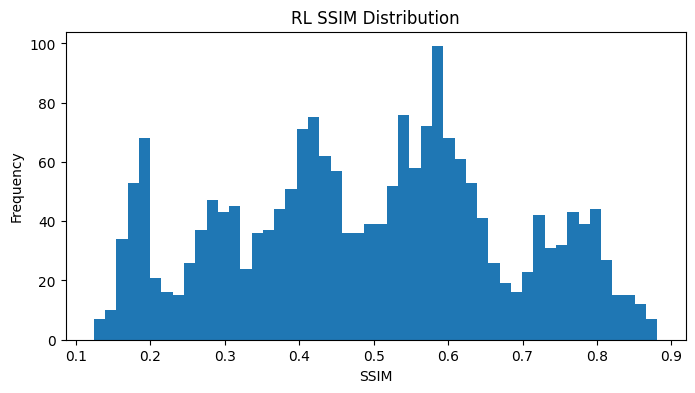

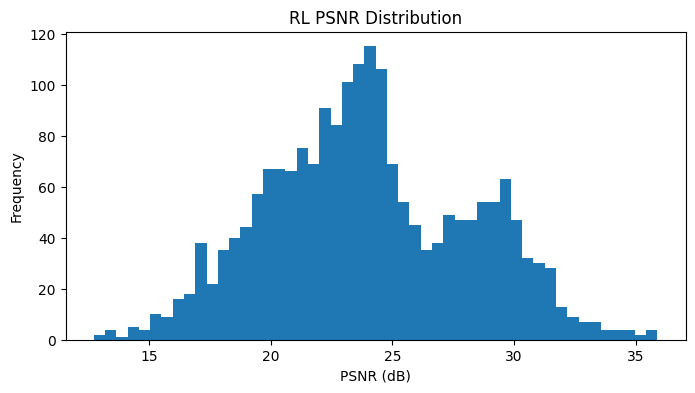

In [9]:
# Richardson-Lucy Deconvolution Benchmark Setup
"""
This canvas sets up the environment to benchmark Richardson-Lucy deconvolution
on the MRI test dataset. It includes all necessary imports, dataset loader,
PSF/kernel definition, and placeholders for running the RL algorithm.
"""
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import zipfile, io
from pathlib import Path
from PIL import Image
from pytorch_msssim import ssim
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration
from tqdm import tqdm
import math

# ---------------------------------------------
# 4. RL Deconvolution Execution & Metrics
# ---------------------------------------------
rl_mse, rl_ssim, rl_psnr = [], [], []
for noisy, clean in tqdm(test_loader, desc='RL Benchmark'):
    # Denormalize to [0,1]
    noisy_den = noisy * std[0] + mean[0]
    clean_den = clean * std[0] + mean[0]
    # Numpy arrays: shape (B, H, W)
    noisy_np = noisy_den.squeeze(1).cpu().numpy()
    clean_np = clean_den.squeeze(1).cpu().numpy()
    # Batch processing
    for i in range(noisy_np.shape[0]):
        img = noisy_np[i]
        gt  = clean_np[i]
        # Richardson-Lucy deconvolution
        deconv = restoration.richardson_lucy(img, psf, 30)
        # Compute MSE
        mse_i = ((deconv - gt)**2).mean()
        rl_mse.append(mse_i)
        # Compute SSIM: convert to torch tensor shape (1,1,H,W)
        deconv_t = torch.from_numpy(deconv).unsqueeze(0).unsqueeze(0)
        gt_t     = torch.from_numpy(gt).unsqueeze(0).unsqueeze(0)
        ssim_i = ssim(deconv_t, gt_t, data_range=1.0, size_average=True).item()
        rl_ssim.append(ssim_i)
        # Compute PSNR
        rl_psnr.append(10 * math.log10(1.0 / mse_i))

# Compute averages
avg_mse  = sum(rl_mse) / len(rl_mse)
avg_ssim = sum(rl_ssim) / len(rl_ssim)
avg_psnr = sum(rl_psnr) / len(rl_psnr)
print(f"RL Benchmark - MSE: {avg_mse:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}dB")

# Plot histograms
plt.figure(figsize=(8,4))
plt.hist(rl_mse, bins=50)
plt.title('RL MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rl_ssim, bins=50)
plt.title('RL SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rl_psnr, bins=50)
plt.title('RL PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.show()
